In [181]:
import numpy as np
import matplotlib.pyplot as plt
import MCMC

import itertools
import numpy.linalg

%matplotlib notebook

import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 5)

# Functions to generate matrices

Model : $\mathcal{H} = -\frac{1}{2} \sum_{ij} s_i J_{ij} s_j - \sum_i h_i s_i$
1D chain of length N with periodic bcs : $s_N = s_0$


In [155]:
def generate_J(N, j, dim=1, pbc=True):
    T = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)
    
    if pbc : 
        T[0,N-1] = 1
        T[N-1,0] = 1

    if dim == 1 : 
        return j*(T+NNN)
    if dim == 2:
        I = np.diag( np.ones(N) )
        return j*(np.kron(I,T) + np.kron(T,I))
    if dim == 3:
        I = np.diag( np.ones(N) )
        return j*(np.kron(np.kron(I, T), I) + np.kron(np.kron(T, I), I) + np.kron(I, np.kron(I,T)) )

def generate_K(N, beta, j, dim=1, pbc=True):
    J = generate_J(N, j, dim=dim, pbc=pbc)
    K = beta*J + 2.5*dim*beta*np.abs(j)*np.diag(np.ones(N**dim))
    
    return K, J


def generate_H(N, beta, h, dim=1):
    return beta*h*np.ones( N**dim )



def energy(sample):
    return -0.5 * sample.T @ J_matrix @sample - h_matrix.T @ sample

def generate_NN(N, beta, jnn, dim=1, pbc=True):
    NN = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)

    if pbc : 
        NN[0,N-1] = 1
        NN[N-1,0] = 1
    NN *= jnn

    if dim == 1 : 
        J = NN
    if dim == 2:
        I = np.diag( np.ones(N) )
        J = np.kron(I,NN) + np.kron(NN,I)
    if dim == 3:
        I = np.diag( np.ones(N) )
        J = np.kron(np.kron(I, NN), I) + np.kron(np.kron(NN, I), I) + np.kron(I, np.kron(I,NN))

    K = beta*J + 2.5*dim*beta*np.abs(jnn)*np.diag(np.ones(N**dim))
    return K,J

def generate_NNN(N, beta, jnn, jnnn, dim=1, pbc=True):
    T = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)
    if pbc : 
        T[0,N-1] = 1
        T[N-1,0] = 1

    if dim == 1 : 
        NNN = np.diag(np.ones(N-2), 2) + np.diag(np.ones(N-2), -2)
        if pbc : 
            NNN[0,N-2] = 1
            NNN[N-2,0] = 1
        J = jnn*T + jnnn*NNN
    if dim == 2:
        I = np.diag( np.ones(N) )
        J = jnn*np.kron(I,T) + jnn*np.kron(T,I) + jnnn*np.kron(T,T)
    if dim == 3:
        I = np.diag( np.ones(N) )
        J = jnn*( np.kron(np.kron(I, T), I) + np.kron(np.kron(T, I), I) + np.kron(I, np.kron(I,T)) )
        J += jnnn*( np.kron(np.kron(T, I), T) + np.kron(np.kron(I, T), T) + np.kron(T, np.kron(T,I)) )

    K = beta*J + 6*dim*beta*max(np.abs(jnn),np.abs(jnnn))*np.diag(np.ones(N**dim))
    return K,J

## Testing the implementation

<IPython.core.display.Javascript object>


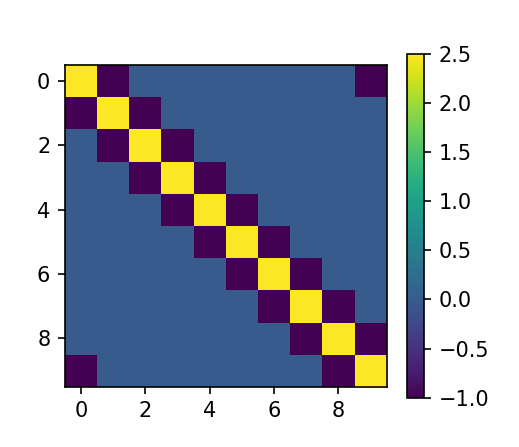

In [16]:
# verify form of K
K_test, J_test = generate_NN(10,beta=1,jnn=-1,jnnn=2,dim=1)
img = plt.imshow(K_test)
plt.colorbar(img)

In [34]:
# Testing eigendecomposition

K_test, J_test = generate_NNN(10,beta=1,jnn=-1,jnnn=1,dim=1)
#print(J_matrix, K_matrix)
values, vectors = np.linalg.eigh(K_test)
print(values)
#J_matrix
#s = np.random.normal(0,1, 2)
#print(f'Initial basis : {s.T @ K_test @ s}')

#print(f'eigenbasis {s.T @ vectors.T @ np.diag(values) @ vectors @ s}')

print(values <= 0)


[3.69951151 4.         4.62028398 5.         5.         5.58578644
 5.83608332 8.         8.41421356 9.84412119]
[False False False False False False False False False False]


In [52]:
# Verify positive-definiteness
for d in [1]:
    for N in range(2,60):
        K_matrix, J_matrix = generate_NNN(N,beta=1,jnn=-1,jnnn=-1,dim=d, pbc=True)
        values = np.linalg.eigvalsh(K_matrix)

        if (values <= 0).any() : 
            print(f'{d}, {N}, {values[values<=0]}')
            

Tests for diag = 2.5*|J|*d, for up to 80, 60, 15 spins for d=1,2,3 respectively

For j = -1 : 
d = 1,2,3 : None with or without PBC

For j = 1: 
d = 1,2,3 : None with or without PBC

Tested for NN with diag = 6*|max(jnn, jnnn)|*d

<IPython.core.display.Javascript object>


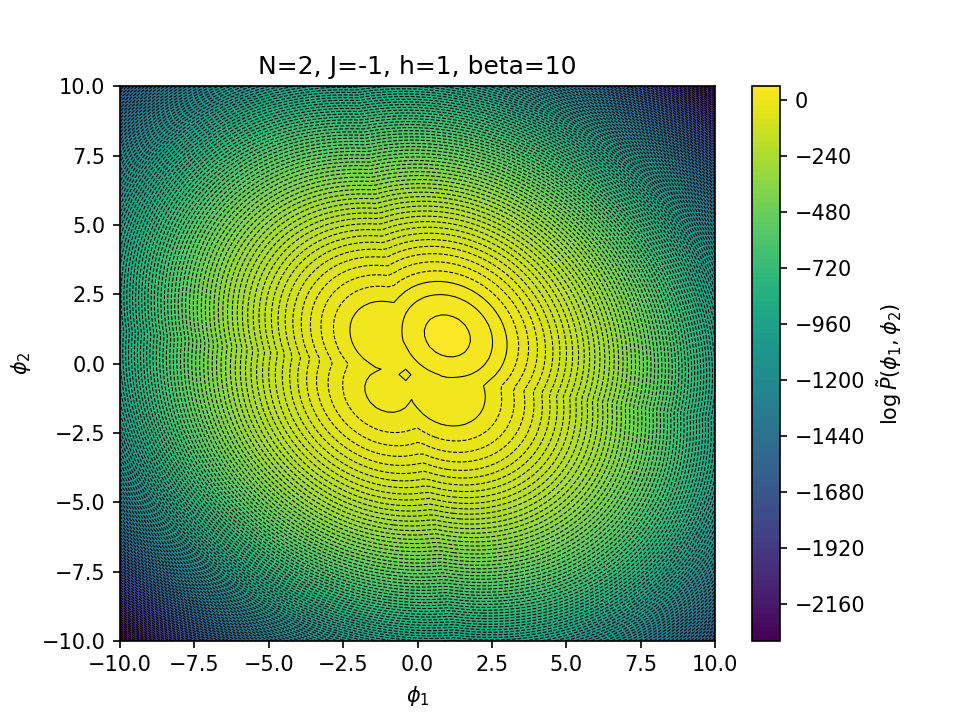

1.0 1.0


In [77]:
# Verify gaussian shape
phi = np.linspace(-10, 10, 101)
phi1, phi2 = np.meshgrid(phi, phi)

N = 2
J = -1
h = 1
beta = 10

K, J_test = generate_NNN(2,beta=1,jnn=4,jnnn=1,dim=1, pbc=True)
H = generate_H(N, beta=beta, h=h)

p = np.zeros( (101,101) )
for k in range(101):
    for j in range(101):
        p[k,j] = log_prob( np.array([phi[k],phi[j]]) )

#p = np.exp(p)


fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.contourf(phi, phi, p, levels=150)
ax.contour(phi, phi, p, levels=150, colors='black', linewidths=.5)

#im = ax.scatter(phi1, phi2,c=p)
cbar = plt.colorbar(im)
cbar.set_label(r'$\log \tilde{P}(\phi_1, \phi_2)$')
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\phi_2$')

plt.title(f'N={N}, J={J}, h={h}, beta={beta}')

#plt.savefig(f'LogDistribution_J={J}.png', bbox_inches = 'tight')

plt.show()
i,j = np.unravel_index(np.argmax(p, axis=None), p.shape)

print(phi[i], phi[j])

### Analytical solutions for : 
- Partition function $Z$
- Magnetization $M = \frac{1}{N} \sum_i \langle s_i \rangle$
- Correlation $\langle s_i s_j \rangle$

In [55]:
def partition_function():
    b = np.exp(beta*J)*np.cosh(beta*h)
    sq = np.sqrt( np.exp(2*beta*J)*np.sinh(beta*h)**2 + np.exp(-2*beta*J) )
    
    l1 = b + sq
    l2 = b - sq
    
    return l1**N + l2**N


def magn():
    b = np.exp(beta*J)*np.cosh(beta*h)
    sq = np.sqrt( np.exp(2*beta*J)*np.sinh(beta*h)**2 + np.exp(-2*beta*J) )
    
    l1 = b + sq
    l2 = b - sq
    
    Z = l1**N + l2**N
    
    db = np.exp(beta*J)*np.sinh(beta*h)
    
    m = (db + 1/sq *np.exp(2*beta*J)*np.sinh(beta*h)*np.cosh(beta*h) ) * l1**(N-1)
    m+= (db - 1/sq *np.exp(2*beta*J)*np.sinh(beta*h)*np.cosh(beta*h) ) * l2**(N-1)
    
    return m/Z

'''
def correlation(i,j):
    b = np.exp(beta*J)*np.cosh(beta*h)
    sq = np.sqrt( np.exp(2*beta*J)*np.sinh(beta*h)**2 + np.exp(-2*beta*J) )
    
    l1 = b + sq
    l2 = b - sq
    
    m = (l1**N + l2**N)*(l1 + l2 -2*np.exp(beta*h+beta*J))**2
    m+= (l1**(N-i+j) * l2**(i-j) + l2**(N-i+j) * l1**(i-j)) * (2*l1 - 2*np.exp(beta*h+beta*J)) * (2*np.exp(beta*h+beta*J) - 2*l2)
    m/= (l1 - l2)**2
    
    return m/(l1**N + l2**N)
'''

def correlation(i,j):
    b = np.exp(beta*J)*np.cosh(beta*h)
    sq = np.sqrt( np.exp(2*beta*J)*np.sinh(beta*h)**2 + np.exp(-2*beta*J) )
    
    l1 = b + sq
    l2 = b - sq
    
    m = np.cosh(beta*h) * (l1**N - l2**N)/sq + N*np.exp(3*beta*J)*np.sinh(beta*h)**2 * (l1**N + l2**N)
    m *= N*np.exp(beta*J)
    m /= 1 + np.exp(4*beta*J)*np.sinh(beta*h)**2
    
    
    return m/(l1**N + l2**N)

In [56]:
'''
# Test wether m(h) has the right shape
J = 1
h = -0.2
print(magn())
print(magn_derivative())
print(discrete_magnetization(5))

x = np.linspace(-2, 2, 100)
m1 = np.zeros(100)
m2 = np.zeros(100)
m3 = np.zeros(100)

for k in range(100):
    J = x[k]
    m1[k] = magn()
    m2[k] = magn_derivative()
    m3[k] = discrete_magnetization(4)

plt.figure()
#plt.plot(x, m1) # no
plt.plot(x, m2)
#plt.plot(x, m3) # no
plt.legend(range(3))
plt.show()
'''

'\n# Test wether m(h) has the right shape\nJ = 1\nh = -0.2\nprint(magn())\nprint(magn_derivative())\nprint(discrete_magnetization(5))\n\nx = np.linspace(-2, 2, 100)\nm1 = np.zeros(100)\nm2 = np.zeros(100)\nm3 = np.zeros(100)\n\nfor k in range(100):\n    J = x[k]\n    m1[k] = magn()\n    m2[k] = magn_derivative()\n    m3[k] = discrete_magnetization(4)\n\nplt.figure()\n#plt.plot(x, m1) # no\nplt.plot(x, m2)\n#plt.plot(x, m3) # no\nplt.legend(range(3))\nplt.show()\n'

In [131]:
# Log of the unnormalized probability distribution in Eq. (4)
def log_prob(phi):
    '''
    phi : vector at evaluation
    '''
    
    # Exponential part
    p = -0.5 * phi.T @ K @ phi
    
    # Product of i part
    x = H + K@phi
    p += np.sum( np.abs(x) + np.log1p(np.exp(-2*np.abs(x))) )
    
        
    return p

def discrete_prob(s):
    '''
    Probability in the spin space
    '''
    return 0.5*beta*s.T @ J_matrix @ s + H@s

# MCMC

## Single MCMC convergence

In [88]:
N = 6
J = 1
h = 1

beta = 1

K, J_matrix = generate_NNN(N,beta=1,jnn=-1,jnnn=-1,dim=1, pbc=True)
H = generate_H(N, beta=beta, h=h)


phi0 = np.random.normal(0, 5, size=N)

n_MCMC = int(1e5)
sampler = MCMC.Continuous(std=1.5)
#sampler = MCMC.Multivariate(cov=np.linalg.inv(K))
list_samples = sampler.run(phi0, log_prob, n_MCMC)

#s0 = np.random.choice([-1.0, 1.0], N )
#discrete_engine = MCMC.Discrete()
#discrete_samples = discrete_engine.run(s0, discrete_prob, n_MCMC)

Acceptance rate : 0.35949


In [171]:
m_burnt

array([1.38777878e-17, 1.38777878e-17, 1.38777878e-17, 1.38777878e-17,
       1.38777878e-17, 1.90935294e-01, 1.67737647e-01, 2.00000000e-01,
       2.00000000e-01, 2.00000000e-01, 2.00000000e-01, 3.00000000e-01,
       2.00000000e-01, 2.66823529e-01, 2.00000000e-01, 3.17855294e-01,
       7.03512941e-01, 8.51616471e-01, 9.50931765e-01, 9.98851765e-01,
       1.00000000e+00])

<IPython.core.display.Javascript object>


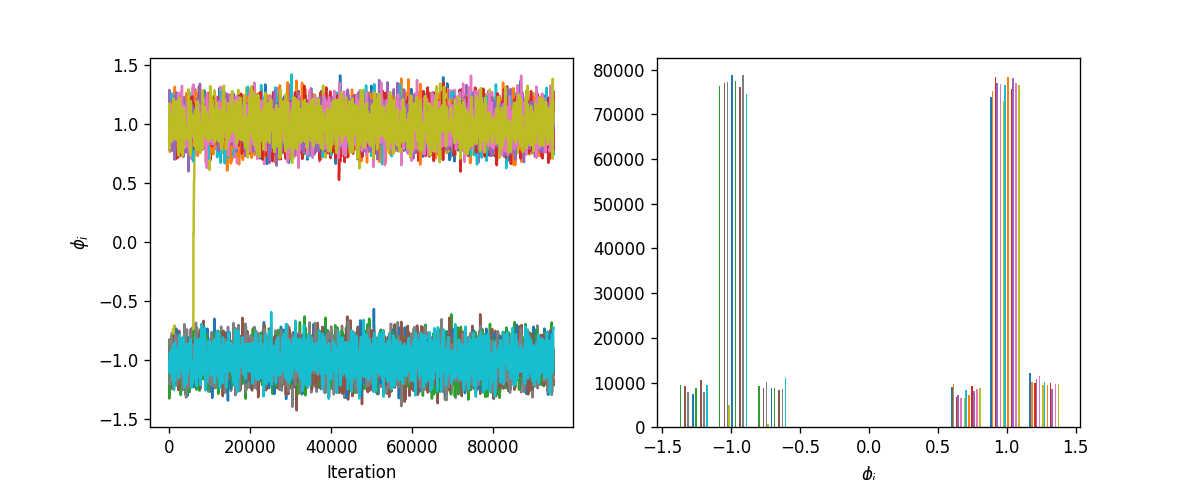

In [172]:
fig = plt.figure()

# Should show the "convergence" of the MCMC
ax1 = fig.add_subplot(121)
ax1.plot(list_samples[7,5000:])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\phi_i$')
#ax1.legend(range(N))
#ax1.set_xlim([19000, 20000])
#ax1.set_ylim([-6, 8])


# Should show the wished probability distribution (gaussians for each component)
ax2 = fig.add_subplot(122)
ax2.hist(list_samples[7,5000:])
ax2.set_xlabel('$\phi_i$')
#ax2.legend(range(N))

#plt.savefig(f'Distribution_J={J}.png', dpi=200, bbox_inches='tight')
plt.show()


<IPython.core.display.Javascript object>


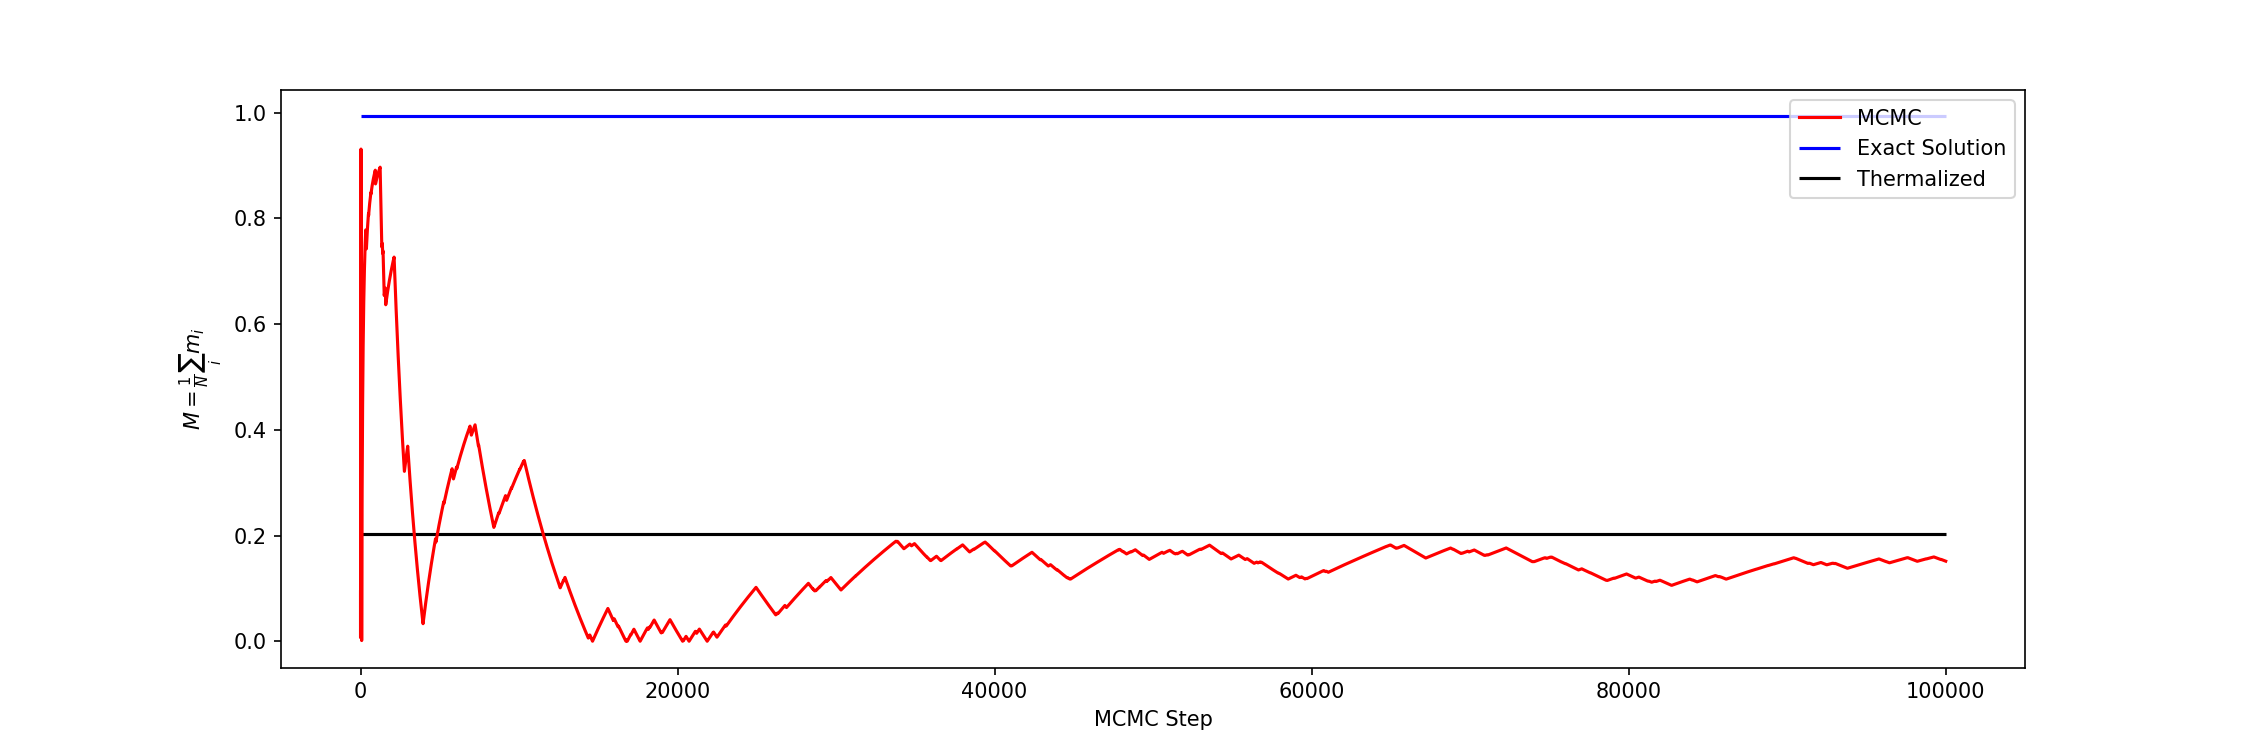

Theoretical : 0.9934238470029021
Obtained : 0.2024452128526624


In [90]:
i = 3

# Compute evolution of the magnetization without burning period
m = np.zeros(n_MCMC)
for k in range(n_MCMC):
    m[k:] += np.tanh(H[i] + K[i]@list_samples[k])
    if k > 0:
        m[k] /=  k
    

# Magnetization with burning period   
m_burnt = np.mean( np.tanh(H[i] + K[i]@list_samples[11000:].T), axis=0 )

# Analytical solution of the magnetization
m_th = magn()


# Compare
plt.figure()
plt.hlines(np.abs(m_th), 0, n_MCMC, label='Exact Solution', color='b')
plt.plot(np.abs(m), label='MCMC', color='r')
plt.hlines(np.abs(m_burnt), 0, n_MCMC, label='Thermalized', color='k')
plt.ylabel(r'$M = \frac{1}{N} \sum_i m_i$')
plt.xlabel('MCMC Step')
#plt.ylim([0.9*np.abs(m_burnt), 1.1*np.abs(m_burnt)])
plt.legend()



plt.show()


print(f'Theoretical : {np.abs(m_th)}')
print(f'Obtained : {np.abs(m_burnt)}')

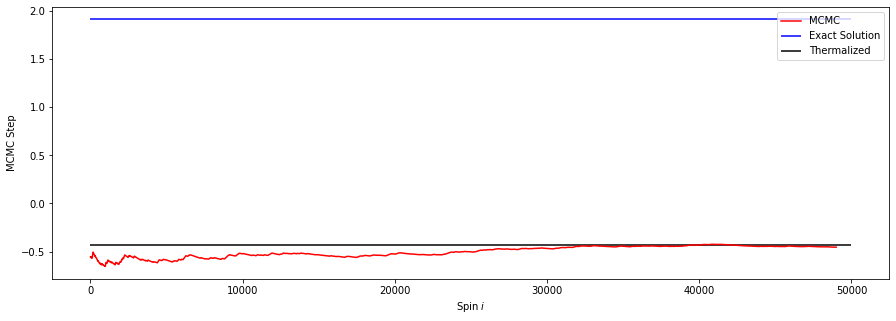

-0.4317845309347571
1.913822276190275


In [8]:
i = 5
j = 2


corr = np.zeros(n_MCMC)
for k in range(n_MCMC):
    corr[k:] += np.tanh(H[i] + K[i]@list_samples[k]) * np.tanh(H[j] + K[j]@list_samples[k])
    if k > 0:
        corr[k] /=  k

        
c_burnt = np.mean( np.tanh(H[i] + K[i]@list_samples[10000:].T)*np.tanh(H[j] + K[j]@list_samples[10000:].T), axis=0 )
c_th = correlation(i,j)

plt.figure()
plt.hlines(c_th, 0, n_MCMC, label='Exact Solution', color='b')
plt.plot(corr[1000:], label='MCMC', color='r')
plt.hlines(c_burnt, 0, n_MCMC, label='Thermalized', color='k')
plt.xlabel('Spin $i$')
plt.ylabel('MCMC Step')
#plt.ylim([0.9*np.abs(m_burnt), 1.1*np.abs(m_burnt)])
plt.legend()



plt.show()


print(c_burnt)
print(c_th)

## Plots of observables

In [185]:
N = 20
beta = 5
jnn = -1
jnnn = -0.3

n_MCMC = int(1e6)
phi0 = np.random.normal(0, 5, size=N)
s0 = np.random.choice([-1.0, 1.0], size=N )



nsimuls = 21
#beta_array = np.array([0.1, 0.5, 1, 1.5, 2, 3, 4, 5])
#std = np.array([5, 2.5, 1.4, 1.2, 1, 0.8, 0.7, 0.6])
h_array = np.linspace(0, 4, nsimuls)

list_samples = np.zeros( (nsimuls, n_MCMC, N) )
discrete_samples = np.zeros( (nsimuls, n_MCMC, N) )
for k in range(nsimuls):
    # Changing parameter
    h = h_array[k]
    
    # Regenerate for correspinding probabilities
    H = generate_H(N, beta=beta, h=h)
    K, J_matrix = generate_NNN(N,beta=beta,jnn=jnn,jnnn=jnnn,dim=1, pbc=True)
    
    # Sample
    sampler = MCMC.Continuous(std = 0.5)
    #sampler = MCMC.Multivariate(cov=np.linalg.inv(K))
    list_samples[k] = sampler.run(phi0, log_prob, n_MCMC)
    
    
    discrete_engine = MCMC.Discrete()
    discrete_samples[k] = discrete_engine.run(s0, discrete_prob, n_MCMC)
    
    '''
    #See walk
    fig = plt.figure()
    plt.title(f'h = {h}')
    
    ax1 = fig.add_subplot(121)
    ax1.plot(list_samples[k,:])
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('$\phi_i$')
    ax1.legend(range(N))


    ax2 = fig.add_subplot(122)
    ax2.hist(list_samples[k,15000:])
    ax2.set_xlabel('$\phi_i$')
    ax2.legend(range(N))


    plt.show()
    '''

Acceptance rate : 0.401564
Acceptance rate : 0.001489
Acceptance rate : 0.402106
Acceptance rate : 0.002329
Acceptance rate : 0.400907
Acceptance rate : 0.00433
Acceptance rate : 0.401614
Acceptance rate : 0.00133
Acceptance rate : 0.401439
Acceptance rate : 0.000953
Acceptance rate : 0.40156
Acceptance rate : 0.00216
Acceptance rate : 0.401605
Acceptance rate : 0.004891
Acceptance rate : 0.402062
Acceptance rate : 0.002092
Acceptance rate : 0.401328
Acceptance rate : 0.005204
Acceptance rate : 0.401912
Acceptance rate : 0.021496
Acceptance rate : 0.402171
Acceptance rate : 0.048429
Acceptance rate : 0.401725
Acceptance rate : 0.024125
Acceptance rate : 0.401755
Acceptance rate : 0.078783
Acceptance rate : 0.40214
Acceptance rate : 0.37365
Acceptance rate : 0.401939
Acceptance rate : 0.153435
Acceptance rate : 0.401896
Acceptance rate : 0.030459
Acceptance rate : 0.401087
Acceptance rate : 0.004351
Acceptance rate : 0.401538
Acceptance rate : 0.000669
Acceptance rate : 0.40172
Acceptan

<IPython.core.display.Javascript object>


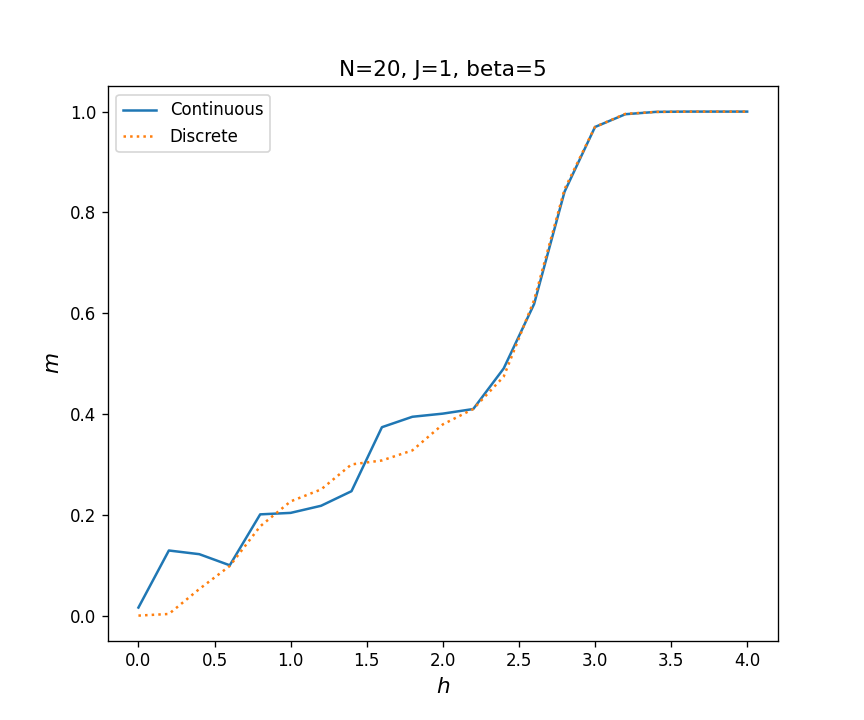

In [186]:
m_burnt = np.zeros(nsimuls)
m_th = np.zeros(nsimuls)
m_discrete = np.zeros(nsimuls)

for i in range(N):
    for k in range(nsimuls):
        h = h_array[k]
        H = generate_H(N, beta=beta, h=h)
        K, J_matrix = generate_NNN(N,beta=beta,jnn=jnn,jnnn=jnnn,dim=1, pbc=True)

        m_burnt[k] += np.mean( np.tanh(H[i] + K[i]@list_samples[k,15000:].T), axis=0 )/N
        #m_th[k] = magn()
        m_discrete[k] += np.mean( discrete_samples[k,15000:,i] )/N

    
plt.figure()
#plt.plot(h_array, m_th, label='Theory')
plt.plot(h_array, m_burnt, label='Continuous')
plt.plot(h_array, m_discrete, label='Discrete', ls=':')
plt.xlabel(r'$h$', fontsize=13)
plt.ylabel(r'$ m $', fontsize=13)
plt.legend()

plt.title(f'N={N}, J={J}, beta={beta}', fontsize=13)
#plt.savefig(f'magnetization_J={J}.png', dpi=200)
plt.show()



<IPython.core.display.Javascript object>


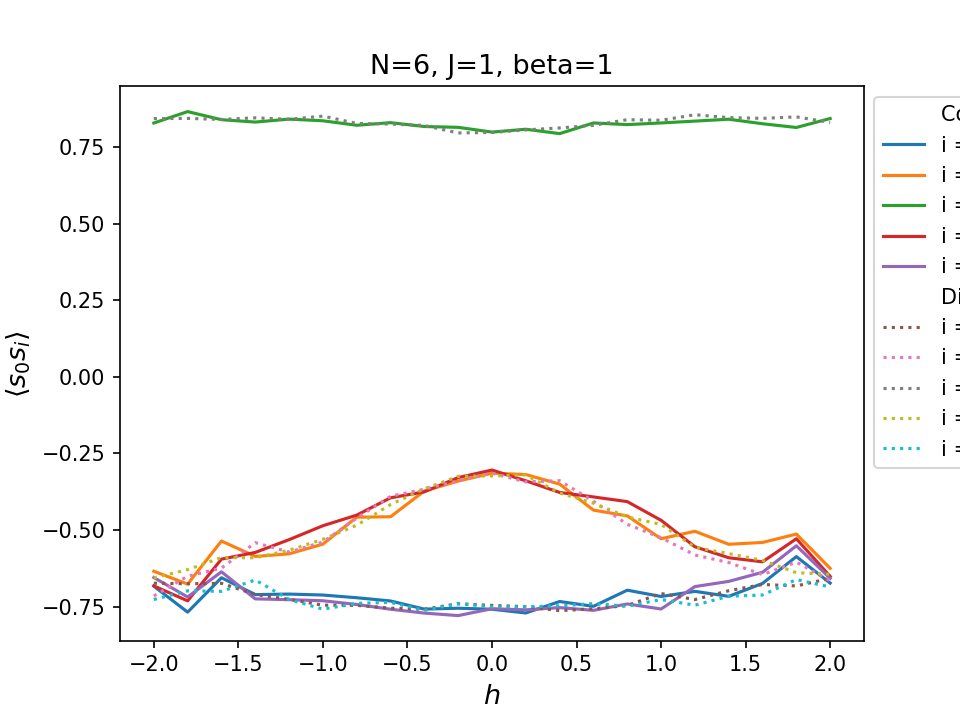

In [97]:
corr = np.zeros( (N-1, nsimuls) )
corr_th = np.zeros( (N-1, nsimuls) )
corr_discrete = np.zeros( (N-1, nsimuls) )
for i in range(1,N):
    for k in range(nsimuls):
        h = h_array[k]
        H = generate_H(N, beta=beta, h=h)
        K, J_matrix = generate_NNN(N,beta=beta,jnn=jnn,jnnn=jnnn,dim=1, pbc=True)

        corr[i-1,k] = np.mean( np.tanh(H[0] + K[0]@list_samples[k,15000:].T)*np.tanh(H[i] + K[i]@list_samples[k,15000:].T), axis=0 )
        corr_th[i-1,k] = correlation(0,i)
        
        corr_discrete[i-1,k] = np.mean( discrete_samples[k,15000:,0] * discrete_samples[k,15000:,i] )


fig,ax = plt.subplots()
plt.title(f'N={N}, J={J}, beta={beta}', fontsize=13)    
for i in range(1,N):
    ax.plot(h_array, corr[i-1], label=f'i = {i}')
for i in range(1,N):
    ax.plot(h_array, corr_discrete[i-1], ls=':',label = f'i = {i}')
#plt.plot(h_array, corr_th[i-1], label=f'Theory')
ax.set_xlabel(r'$h$', fontsize=13)
ax.set_ylabel(r'$\langle s_0 s_i \rangle $', fontsize=13)

#ax.set_xlim([0,max(h_array)])

h, l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = [ph[0]] + h[:N-1] + [ph[1]] + h[N-1:]
labels = ["Continuous :"] + l[:N-1] + ["Discrete :"] + l[N-1:]
plt.legend(handles, labels, ncol=1, bbox_to_anchor=(1,1), loc="upper left")

#plt.savefig(f'Correlation_J={J}.png', dpi=200, bbox_inches='tight')
plt.show()